# Radar Examples For CHORDS
This notebook illustrates some of the concepts of weather radar images that are applicable to the development of CHORDS with respect to the integration of higher-dimensional geoscience data into CHORDS portals. This document and some of the associated tools has been developed by Ryan Gooch of the CSU Radar Group.

## Managing Your Python Environment
I manage my python environments using Anaconda, and would suggest that those using this notebook use that distribution and Jupyter Lab to launch this notebook. In order to do this, it would be best to create a new Anaconda environment and install the relevant packages in that environment. For example, if your environment is called ```radar```, you could generate and activate your environment as such:

```bash
# After installing Anaconda to your home directory or elsewhere on your path
conda create --name radar
# select [y]

# activate the environment
conda activate radar

# install packages
conda install matplotlib
conda install numpy
conda install jupyterlab
conda install ipython
conda install -c conda-forge arm_pyart
conda install colorcet
```

At this point, your environment should be mostly configured and ready to use.

## Custom Data Reader
Since our goal is to use CASA DFW radar data, we will need a custom data reader to be able to understand CASA standards, which does not come with Py-ART. I have created a custom reader called ```read_casa_netcdf``` which can read CASA data into a Py-ART ```radar``` object. This reader is in a module called ```funcs```, in the ```tools``` folder. This will need to be in the same folder that the analysis scripts are run from.

Contact: Ryan Gooch, s.ryan.gooch@gmail.com

## Weather Radar Standards
Py-ART ([github](https://github.com/ARM-DOE/pyart)) is particularly nice in several ways. It allows us to manage the radar data using standardized names from the CF/Radial specification ([document](https://github.com/NCAR/CfRadial/blob/master/current_docs/CfRadialDoc-v2.0-20190203.pdf) [github](https://github.com/NCAR/CfRadial) [standard names](https://github.com/NCAR/CfRadial/blob/master/current_docs/CfRadialStandardNames.20180615.pdf)). It has several plotting utilities to manage spherical coordinates and abstracts out commands to lower printing utilities like ```pcolor``` in ```matplotlib```. It can grid the data to a Cartesian grid if needed. And more.

Since CHORDS needs standardized vocabularies, it will also be important to use the standard names in the CF/Radial specification. To assist this, I've taken an excerpt from the spec and included it in the table below. The table lists potential radar moments we need to support, and their standard names.

### Standard Names Table
| Standard | Short Name | Units | Common Names |
| -------- | ---------- | ----- | ------------ |
| equivalent_reflectivity_factor | DBZ | dBZ | Reflectivity, Zh |
| linear_equivalent_reflectivity_factor | Z | Z | |
| radial_velocity_of_scatterers_away_from_instrument | VEL | m/s | Velocity, Radial Velocity |
| doppler_spectrum_width | WIDTH | m/s | Spectrum Width |
| log_differential_reflectivity_hv | ZDR | dB | Differential Reflectivity, Zdr |
| log_linear_depolarization_ratio_hv | LDR | dB | Linear Depolarization Ratio, LDR |
| log_linear_depolarization_ratio_h | LDRH | dB | |
| log_linear_depolarization_ratio_v | LDRV | dB | |
| differential_phase_hv | PHIDP | degrees | Differential Phase |
| specific_differential_phase_hv | KDP | degrees/km | KDP, Specific Phase |
| cross_correlation_ratio_hv | RHOHV | no | CC, Copolar Correlation |
| signal_to_noise_ratio | SNR | dB | Signal to Noise Ratio, SNR |
| normalized_coherent_power | NCP | unitless | NCP | 
| corrected_equivalent_reflectivity_factor | DBZc | dBZ | Corrected Reflectivity |
| corrected_radial_velocity_of_scatterers_away_from_instrument | VELc | m/s | Corrected Velocity |
| corrected_log_differential_reflectivity_hv | ZDRc | dB | Corrected Zdr, Corrected Differential Reflectivity |
| radar_estimated_rain_rate | RRR | mm/hr | Rain Rate, RR |
| radar_echo_classification | REC | categorical | Hydrometeor ID, Hydroclass | 

## Weather Radar Variable Discussion
It is perhaps useful here to discuss which variables are most important in CHORDS. 
The list above is not exhaustive, but these are some of the most commonly referenced variables.
Depending on what a user wants to do, different variables are important.
To illustrate this, see potential use cases below.

### Use Case: Filtering out Clutter in Zh
It is common when plotting radar data to filter out non-weather echoes.
There are two main ways that this is done:
1. Removing "invalid" or "NaN" radar gates
2. Filtering by threshold for another radar variable (like SNR)

The former method must be supported as radar data often has missing values, as determined by the signal processing functions on the radar itself.
The common convention is to use a nonsensical value in place of actually using "NaN," but it means the same thing.
The value most commonly used is -99900, but the exact value is usually available in the data itself.

The latter method is a little more complicated, whereby range gates are filtered if they do not meet some threshold. 
Common fields used to threshold are SNR and NCP.
For example, a user may wish to filter any range gate where the signal is not at least twice as strong as the noise.
To do this, they may say "filter out all range gates in Zh where SNR < 3 db."

### Use Case: Searching for Hail
One of the great benefits in using dual-polarization weather radars is that we can find shape parameters in the scatterers in the atmosphere in addition to return power, allowing hydrometeor classification to occur.
In searching for hail, a radar image viewer needs to differentiate actual hail signatures from large raindrops and heavy rain.
A simple way to do this is to examine Zh and Zdr, since hail scatterers tend to be more spherical, whereas rain drops become more oblate as they get larger.
The rain drops in turn produce a higher value in Zdr, since that is the ratio of Zh and Zv, while hail may tend to be closer to zero.

## Important Variables
Overall, it will be important to have access to multiple measurements, and some more so than others. 
For example, the radar variables I would suggest including as a first pass include:

* Zh - Radar Reflectivity
* Zdr - Differential Reflectivity
* rho_hv - Cross Pol Correlation
* KDP - Specific Differential Phase
* Vel - Radial Velocity
* sigma_v - Spectrum Width
* SNR - Signal to Noise Ratio 
* HID - Hydrometeor Classification
* RR - Rain Rate

These last two are interesting because the CASA DFW network has merged radar products encompassing the greater Dallas-Fort Worth metro area, and this represents another use case, where instead of having a radar at the center of the scan, there is a large geospatial region of data available.
This may require a different set of functionality and to be added later, but it seems worth mentioning now.

In [2]:
import os # for managing path concatenation
import pyart # for plotting radar data, handling the data itself

import matplotlib.pyplot as plt # plotting utility for this notebook
import matplotlib as mpl # handling plot parameters like fonts
import numpy as np # array data manipulation

import gzip # unzipping the netcdf
import shutil # temporary file creation for unzipped netcdf file
import colorcet as cc # perceptually uniform colormaps

from matplotlib.colors import LinearSegmentedColormap # to build colormaps

# Ryan's tools for custom CASA data reader and certain other data utilities
from tools.funcs import read_casa_netcdf#, impute_missing, scale

## Open the radar file and examine

In [3]:
EXAMPLE_PATH = './data'
EXAMPLE_FILE = 'midlothian.tx-20160727-223325.netcdf.gz'

In [4]:
nc_file = os.path.join(EXAMPLE_PATH, EXAMPLE_FILE)

with gzip.open(nc_file, 'rb') as zipped_nc_file:
    with open('temp.nc', 'wb') as nc_file:
        shutil.copyfileobj(zipped_nc_file, nc_file)

In [5]:
radar = read_casa_netcdf('temp.nc')

In [6]:
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (667,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (667,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	Reflectivity:
		data: <ndarray of type: float32 and shape: (667, 675)>
		Units: dBz
	Velocity:
		data: <ndarray of type: float32 and shape: (667, 675)>
		Units: MetersPerSecond
	SpectralWidth:
		data: <ndarray of type: float32 and shape: (667, 675)>
		Units: MetersPerSecond
	DifferentialReflectivity:
		data

## Plots

In [7]:
mpl.rcParams["font.size"] = 24

### Colormaps
Colormaps matter quite a bit in assisting human visualization, and different data value ranges, along with the phenomena they represent, require different colormaps.
To start with, I've plotted Corrected Reflectivity with the National Weather Service (NWS) Reflectivity colormap.
It is a 'rainbow' colormap, and is available from several sources, including Py-ART.
For this and all colormaps, however, I can provide lists of RGB tuples or whatever format needed, if desired.

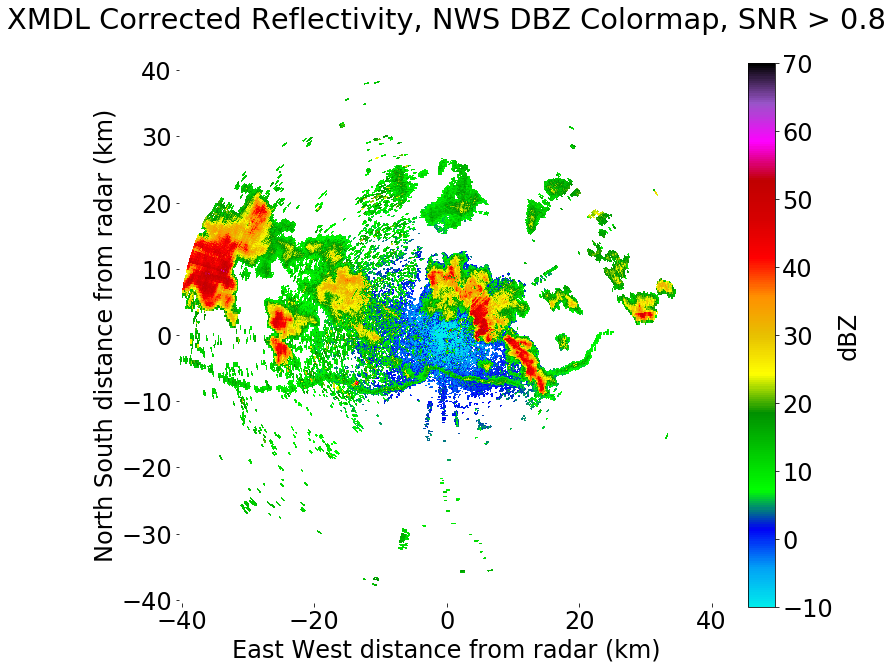

In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'CorrectedReflectivity', 
    0, 
    vmin = -10, 
    vmax = 70, 
    cmap = pyart.graph.cm.NWSRef, # specifying colormap from pyart
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'dBZ',
    title = 'XMDL Corrected Reflectivity, NWS DBZ Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

### Colorcet
I like the colorcet library since it provides perceptually uniform colormaps, where "increases" in color scale perceptually to increases in data.
More information can be found at their [website](https://colorcet.pyviz.org/).
We don't have to use these specifically, but I will show ones I consider to be appropriate for the radar variables below.

I'll first show Corrected Reflectivity.
**Note:** We should use NWS Reflectivity colormap. 
This is only meant as an example for the sake of comparison.

#### Corrected Reflectivity

In [9]:
# build the colormap into something compatible with matplotlib
# rainbow colormap
lsc = LinearSegmentedColormap.from_list('cc',cc.rainbow_bgyrm_35_85_c71)

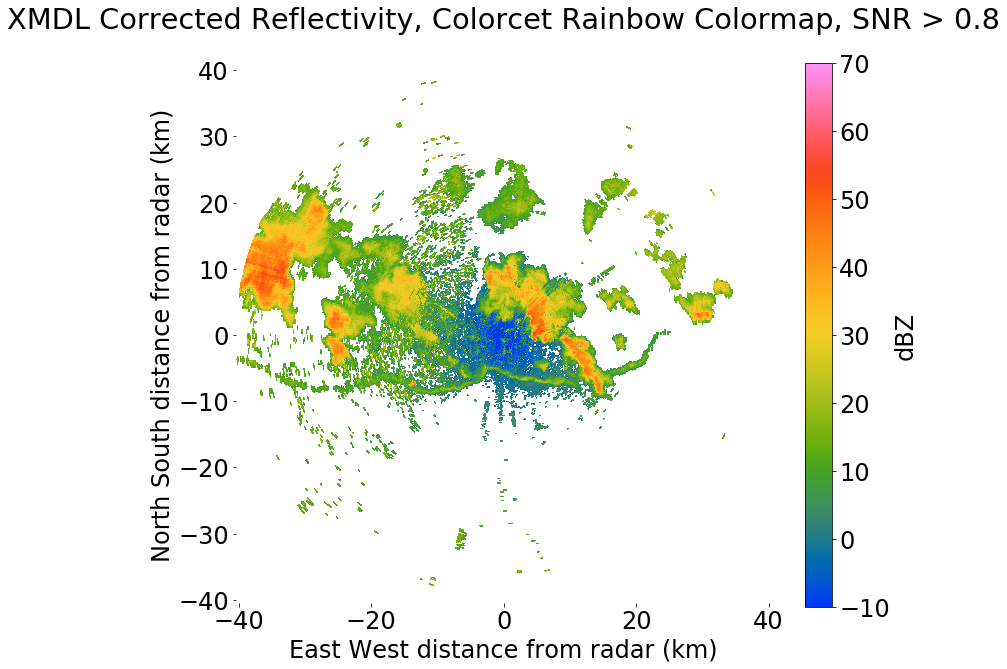

In [10]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'CorrectedReflectivity', 
    0, 
    vmin = -10, 
    vmax = 70, 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'dBZ',
    title = 'XMDL Corrected Reflectivity, Colorcet Rainbow Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

#### Corrected Differential Reflectivity

In [11]:
lsc = LinearSegmentedColormap.from_list('cc',cc.coolwarm)

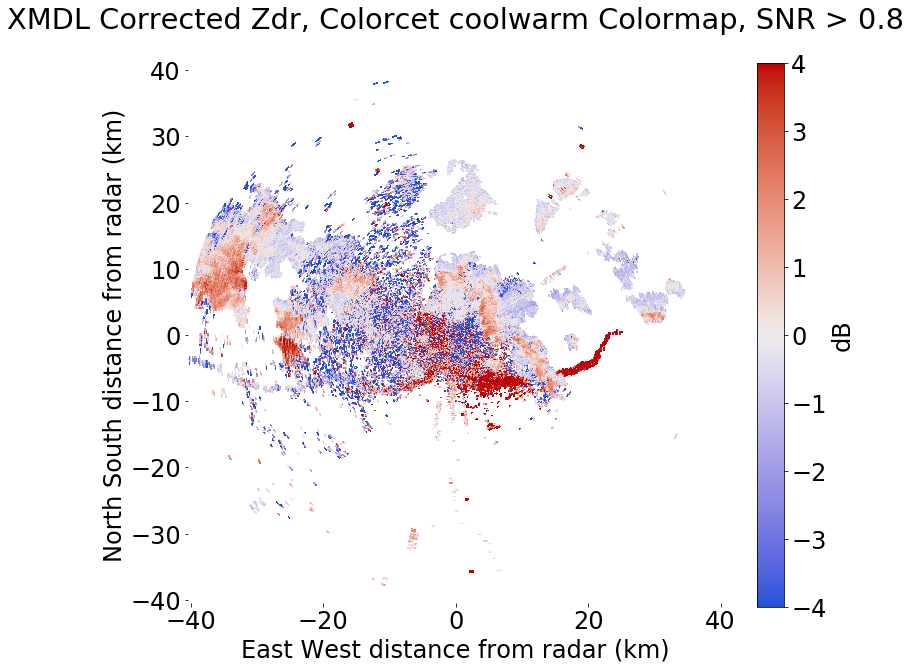

In [12]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'CorrectedDifferentialReflectivity', 
    0, 
    vmin = -4, 
    vmax = 4, 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'dB',
    title = 'XMDL Corrected Zdr, Colorcet coolwarm Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

#### Cross Polar Correlation

In [13]:
lsc = LinearSegmentedColormap.from_list('cc',cc.bgyw)

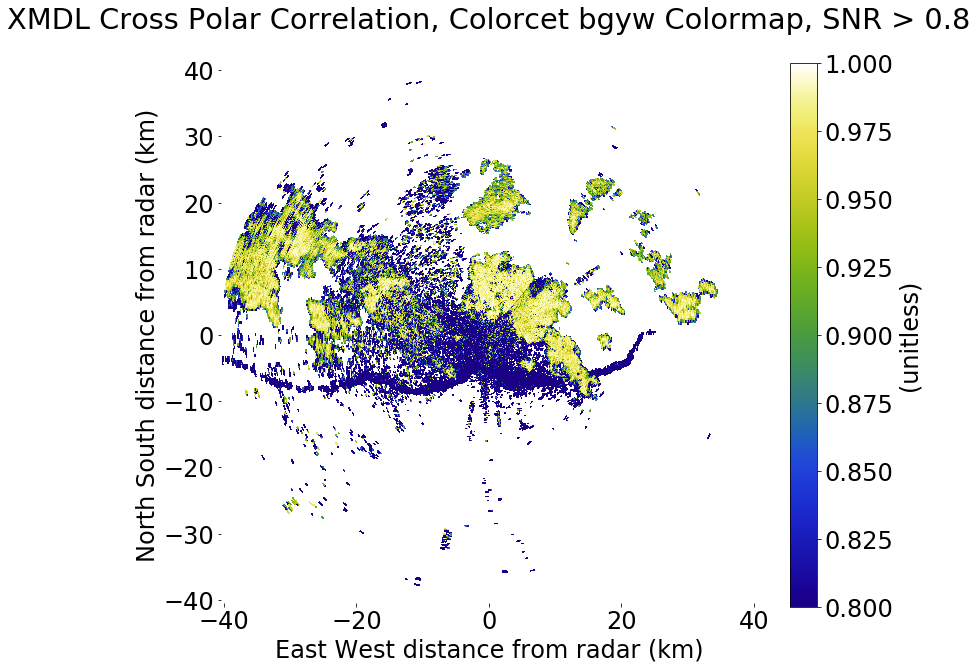

In [14]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'CrossPolCorrelation', 
    0, 
    vmin = 0.8, 
    vmax = 1.0, 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = '(unitless)',
    title = 'XMDL Cross Polar Correlation, Colorcet bgyw Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

### KDP

In [15]:
lsc = LinearSegmentedColormap.from_list('cc',cc.bmy)

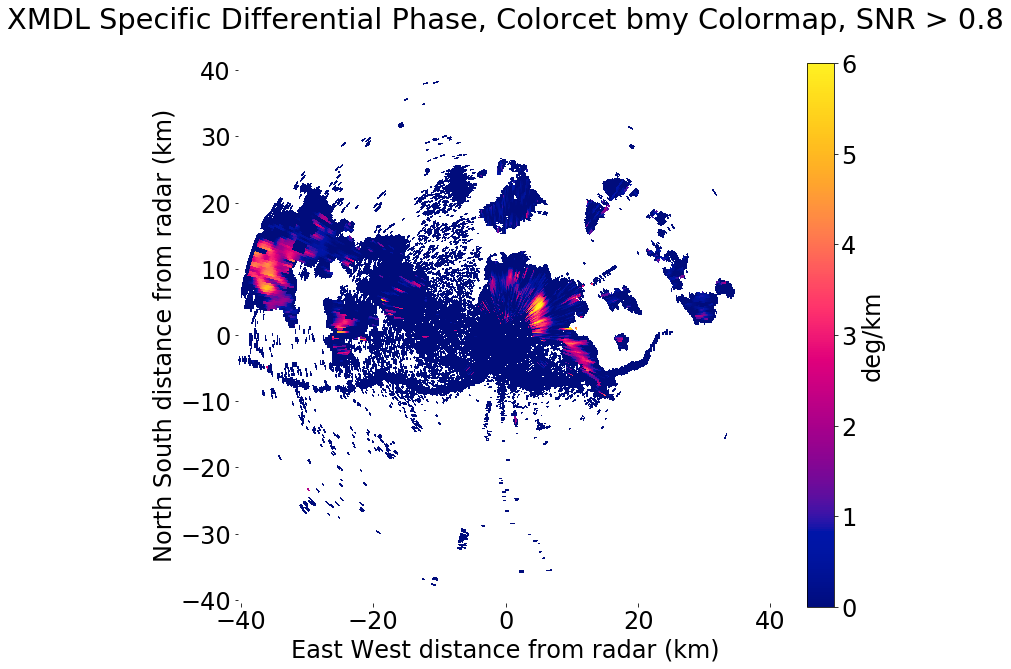

In [16]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'SpecificPhase', 
    0, 
    vmin = 0., 
    vmax = 6., 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'deg/km',
    title = 'XMDL Specific Differential Phase, Colorcet bmy Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

#### Radial Velocity

In [17]:
lsc = LinearSegmentedColormap.from_list('cc',cc.coolwarm)

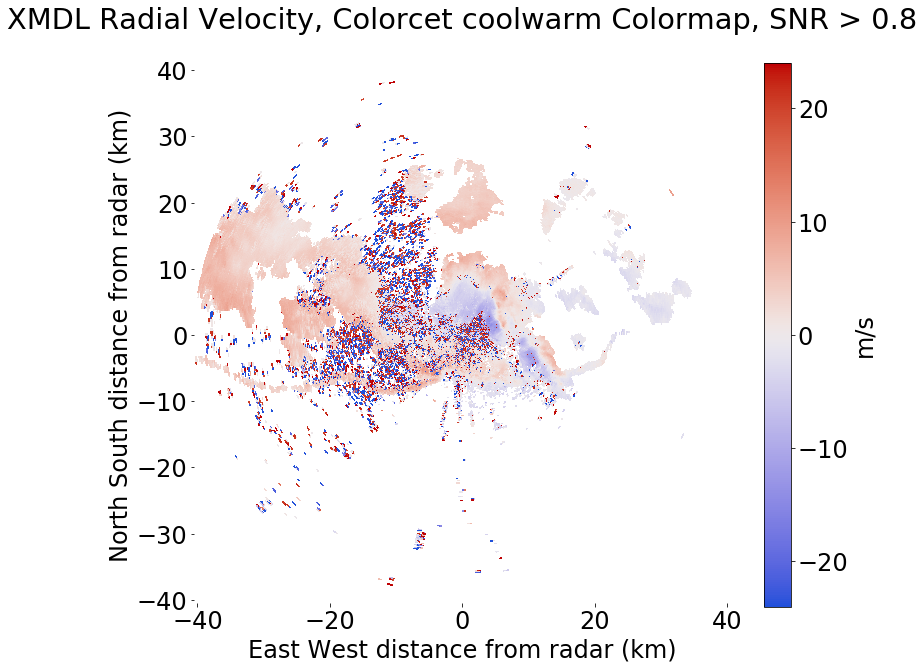

In [18]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'Velocity', 
    0, 
    vmin = -24, 
    vmax = 24, 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'm/s',
    title = 'XMDL Radial Velocity, Colorcet coolwarm Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

#### Spectrum Width

In [20]:
lsc = LinearSegmentedColormap.from_list('cc',cc.fire)

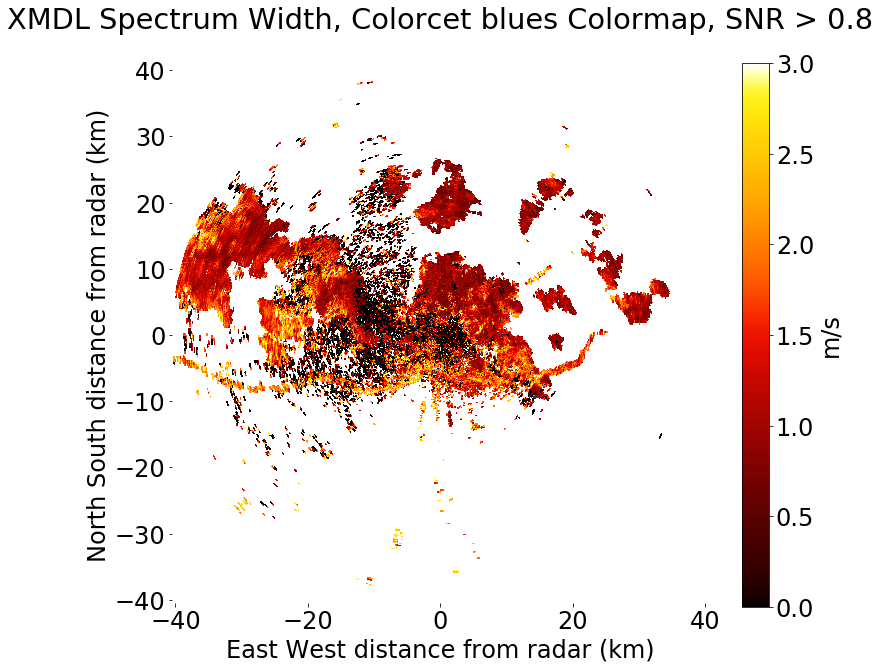

In [21]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'SpectralWidth', 
    0, 
    vmin = 0, 
    vmax = 3, 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'm/s',
    title = 'XMDL Spectrum Width, Colorcet blues Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()

#### Rainfall Rate

In [22]:
lsc = LinearSegmentedColormap.from_list('cc',cc.kgy)

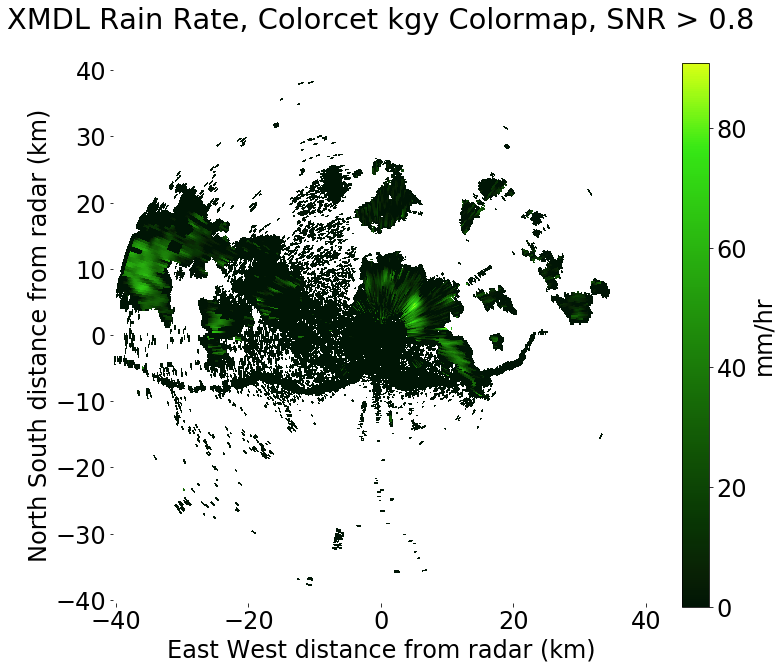

In [23]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, frameon = False)

display = pyart.graph.RadarDisplay(radar)

display.plot(
    'RainfallRate', 
    0, 
    vmin = 0, 
    vmax = np.max(radar.fields['RainfallRate']['data'][:]), 
    cmap = lsc, # specifying colormap from colorcet
    mask_tuple = ['SignalToNoiseRatio',3], # mask SNR values below 3 dB
    colorbar_label = 'mm/hr',
    title = 'XMDL Rain Rate, Colorcet kgy Colormap, SNR > 0.8\n'
)
ax.set_aspect('equal')

plt.show()